# Klasifikasi Gambar Penyakit Pneumonia


## Import Library

In [ ]:
import os, shutil
import zipfile
import random
from random import sample
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [11]:
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import  ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [12]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [13]:
print(tf.__version__)

2.19.0


## Data Loading

In [14]:
import kagglehub

In [15]:
# path = kagglehub.dataset_download("tolgadincer/labeled-chest-xray-images")

# print("Path to dataset files:", path)

Downloading from https://www.kaggle.com/api/v1/datasets/download/tolgadincer/labeled-chest-xray-images?dataset_version_number=1...
100%|██████████| 1.17G/1.17G [06:25<00:00, 3.26MB/s]
Extracting files...

Path to dataset files: /home/nadia/.cache/kagglehub/datasets/tolgadincer/labeled-chest-xray-images/versions/1

## Data Preparation

In [16]:
train_dir = "data/chest_xray/train"
test_dir = "data/chest_xray/test"

combined_dir = "data/chest_xray/dataset"

In [17]:
os.makedirs(combined_dir, exist_ok=True)

In [18]:
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

## Dataset Checking

In [19]:
lung_image = {}

path = "data/chest_xray"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    lung_image[i] = os.listdir(os.path.join(path_sub, i))

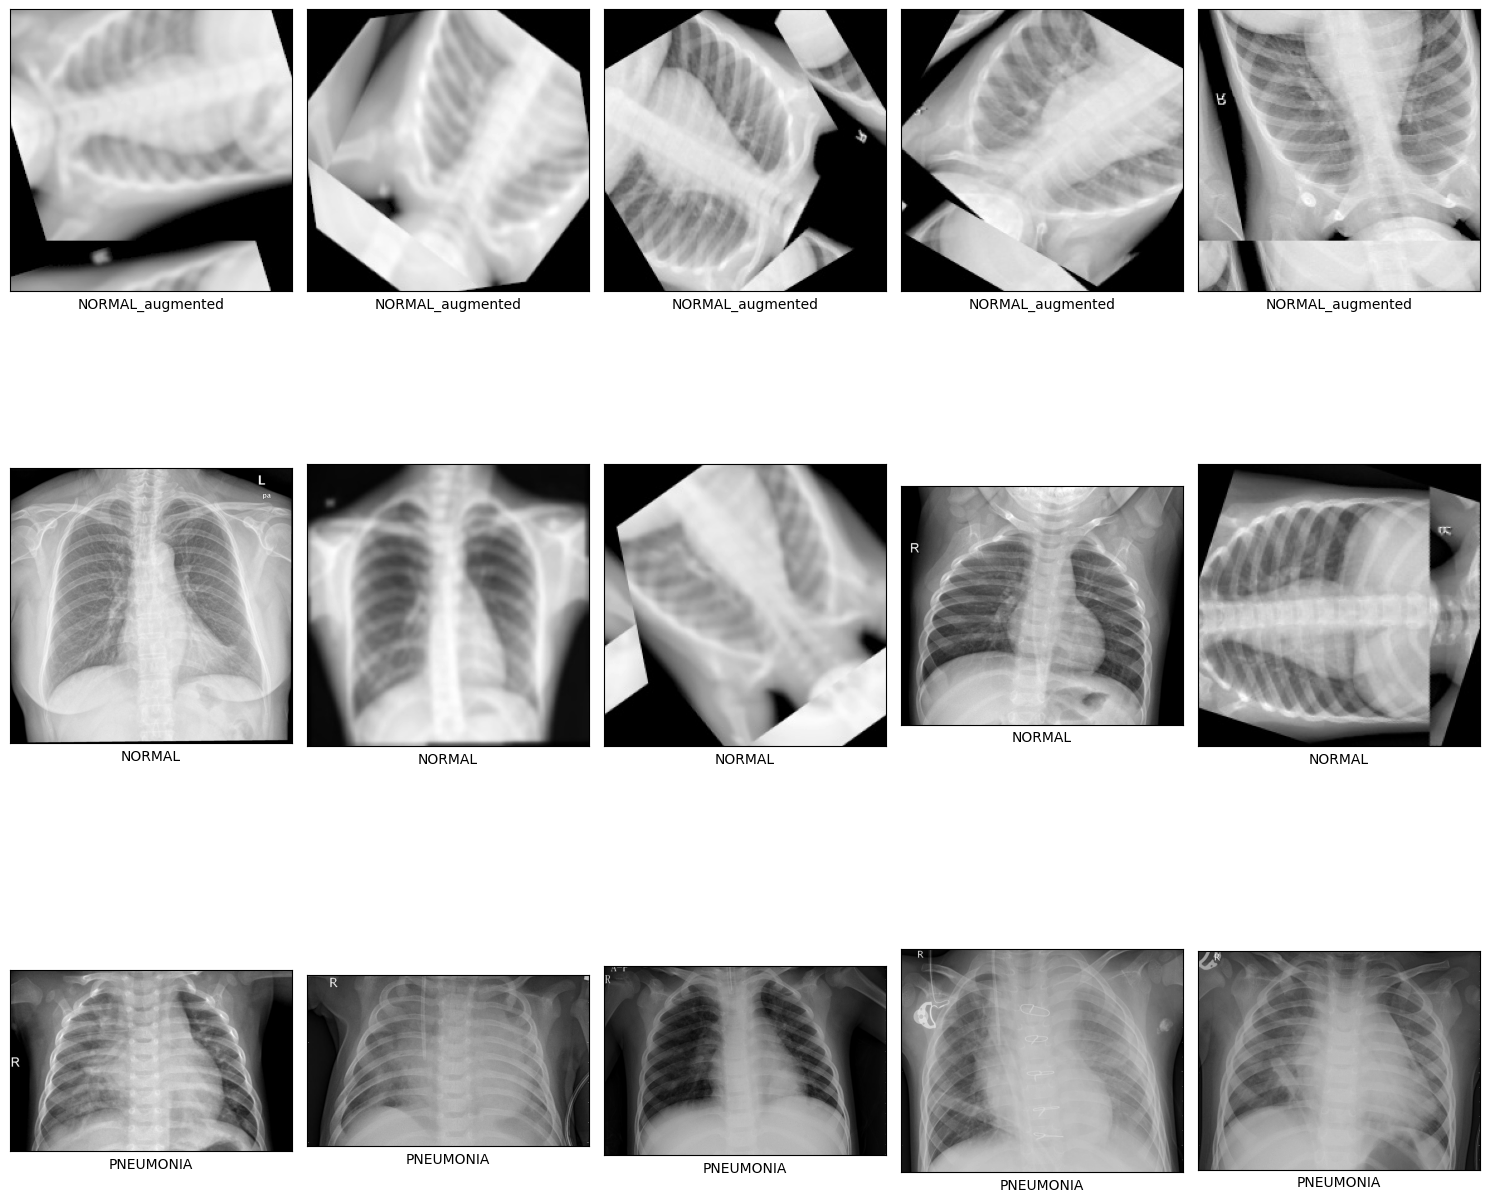

In [20]:
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15,15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L") # convert mjd grayscale
        axs[i,j].imshow(img, cmap='gray')
        axs[i,j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()

## Plot Distribusi

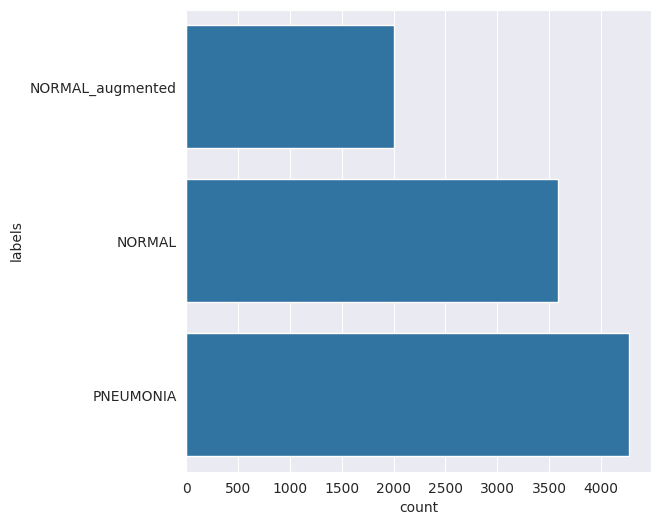

In [21]:
lung_path = "data/chest_xray/dataset/"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, 'labels':labels})

Label = distribution_train["labels"]
plt.figure(figsize=(6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

## Data Augmentation

Berikut adalah beberapa strategi augmentasi gambar yang kita terapkan.

- anticlockwise_rotation adalah ketika gambar diputar ke arah berlawanan dengan jarum jam.
- clockwise_rotation adalah ketika gambar diputar searah dengan jarum jam.
- flip_up_down adalah ketika gambar dibalik secara vertikal dari atas ke bawah.
- sheared adalah ketika gambar diberikan efek pergeseran acak.
- blur adalah ketika gambar diberikan efek kabur atau blur.
- wrap_shift adalah ketika gambar diberikan efek pergeseran melengkung.
- brightness adalah ketika gambar diberikan efek peningkatan kecerahan.

In [22]:
def anticlockwise_rotation(img):
    # Convert if needed
    if img.dtype != np.uint8:
        img = img_as_ubyte(img)
    
    img = cv2.resize(img, (224, 224))
    sudut = random.randint(0, 180)
    return rotate(img, sudut)

def clockwise_rotation(img):
    # Convert if needed
    if img.dtype != np.uint8:
        img = img_as_ubyte(img)
    
    img = cv2.resize(img, (224, 224))
    sudut = random.randint(0, 180)
    return rotate(img, -sudut)

def flip_up_down(img):
    # No color conversion needed for flipping
    img = cv2.resize(img, (224, 224))
    return np.flipud(img)

def add_brightness(img):
    # Convert if needed
    if img.dtype != np.uint8:
        img = img_as_ubyte(img)
    
    img = cv2.resize(img, (224, 224))
    img = adjust_gamma(img, gamma=0.5, gain=1)
    return img

def blur_image(img):
    # Convert if needed
    if img.dtype != np.uint8:
        img = img_as_ubyte(img)
    
    img = cv2.resize(img, (224, 224))
    return cv2.GaussianBlur(img, (9, 9), 0)

def sheared(img):
    # For warp functions, we don't need to convert to uint8
    img = cv2.resize(img, (224, 224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

def warp_shift(img):
    # For warp functions, we don't need to convert to uint8
    img = cv2.resize(img, (224, 224))
    transform = AffineTransform(translation=(0, 40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [23]:
transformations = { 'rotate anticlockwise': anticlockwise_rotation,
                    'rotate clockwise': clockwise_rotation,
                    'warp shift': warp_shift,
                    'blurring image': blur_image,
                    'add brightness' : add_brightness,
                    'flip up down': flip_up_down,
                    'shear image': sheared
                  }

images_path = "data/chest_xray/dataset/NORMAL"
augmented_path = "data/chest_xray/dataset/NORMAL_augmented"

if not os.path.exists(augmented_path):
    os.makedirs(augmented_path)
    print(f"Created directory: {augmented_path}")
else:
    print(f"Directory already exists: {augmented_path}")
    
images = []

for im in os.listdir(images_path):
    images.append(os.path.join(images_path, im))

images_to_generate = 2000
i=1

while i <= images_to_generate:
    image = random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image = original_image.copy()  # Start with a copy of the original
        
        transformation_count = random.randint(1, len(transformations))
        applied_transformations = []
        
        for n in range(transformation_count):
            key = random.choice(list(transformations))
            while key in applied_transformations:  # Avoid applying the same transformation twice
                key = random.choice(list(transformations))
            
            transformed_image = transformations[key](transformed_image)  # Apply to the current result
            applied_transformations.append(key)
        
        new_image_path = "%s/augmented_image_%s.jpg" % (augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)
        
        # Convert to BGR for OpenCV if needed
        if len(transformed_image.shape) == 3 and transformed_image.shape[2] == 3:
            transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR)
            
        cv2.imwrite(new_image_path, transformed_image)
        i = i + 1
        
    except ValueError as e:
        print('could not read the', image, ":", e, 'hence skipping it.')

Directory already exists: data/chest_xray/dataset/NORMAL_augmented


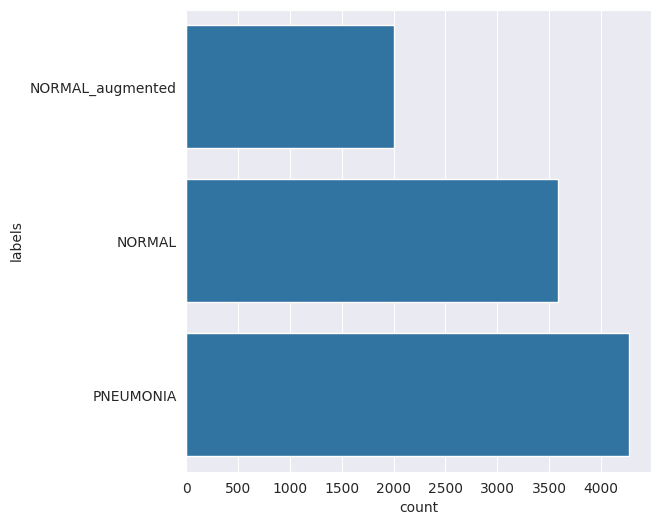

In [24]:
ung_path = "data/chest_xray/dataset/"
 
file_name = []
labels = []
full_path = []
 
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)
 
distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})
 
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

Generated 100 images out of 2000
Generated 200 images out of 2000
Generated 300 images out of 2000
Generated 400 images out of 2000
Generated 500 images out of 2000
Generated 600 images out of 2000
Generated 700 images out of 2000
Generated 800 images out of 2000
Generated 900 images out of 2000
Generated 1000 images out of 2000
Generated 1100 images out of 2000
Generated 1200 images out of 2000
Generated 1300 images out of 2000
Generated 1400 images out of 2000
Generated 1500 images out of 2000
Generated 1600 images out of 2000
Generated 1700 images out of 2000
Generated 1800 images out of 2000
Generated 1900 images out of 2000
Generated 2000 images out of 2000


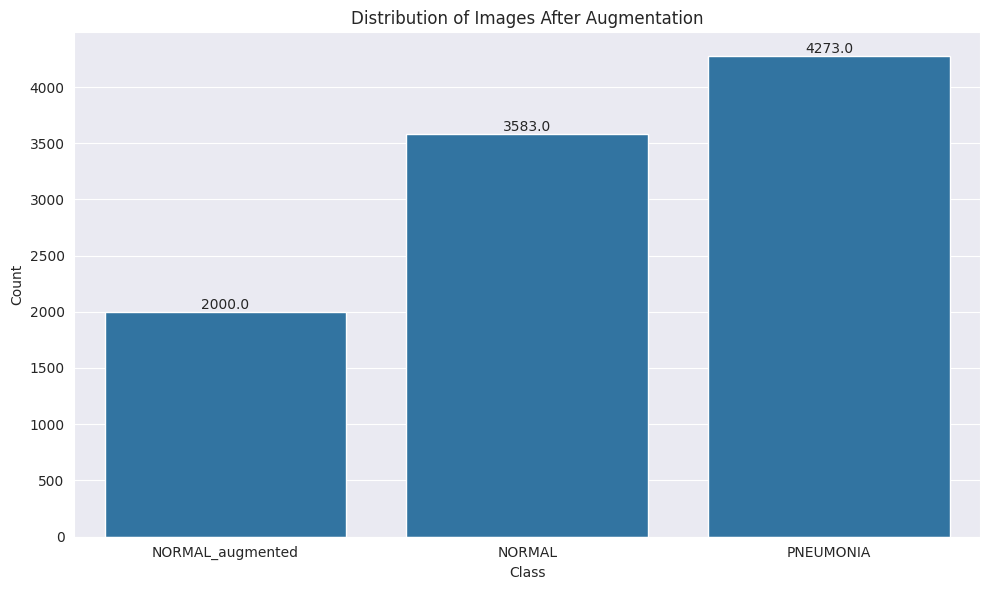

In [25]:
# Step 1: Create augmented images
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

# Source and destination paths
normal_path = "data/chest_xray/dataset/NORMAL"
augmented_path = "data/chest_xray/dataset/NORMAL"  # Save to the same folder to merge them

# Create list of source images
images = []
for im in os.listdir(normal_path):
    images.append(os.path.join(normal_path, im))

# Number of augmented images to generate
images_to_generate = 2000
i = 1

# Create augmented images
while i <= images_to_generate:
    image = random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image = original_image.copy()
        
        transformation_count = random.randint(1, len(transformations))
        applied_transformations = []
        
        for n in range(transformation_count):
            key = random.choice(list(transformations))
            while key in applied_transformations:
                key = random.choice(list(transformations))
            
            transformed_image = transformations[key](transformed_image)
            applied_transformations.append(key)
        
        # Save to the same directory but with "augmented_" prefix
        new_image_path = f"{augmented_path}/augmented_{i}.jpg"
        transformed_image = img_as_ubyte(transformed_image)
        
        if len(transformed_image.shape) == 3 and transformed_image.shape[2] == 3:
            transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR)
            
        cv2.imwrite(new_image_path, transformed_image)
        if i % 100 == 0:
            print(f"Generated {i} images out of {images_to_generate}")
        i = i + 1
        
    except ValueError as e:
        print('Could not read the', image, ":", e, 'hence skipping it.')

# Now create the updated distribution plot
lung_path = "data/chest_xray/dataset/"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot the updated distribution
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")
ax = sns.countplot(x=distribution_train['labels'])
ax.set_title('Distribution of Images After Augmentation')
ax.set_xlabel('Class')
ax.set_ylabel('Count')

# Add count labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Data Splitting

In [26]:
mypath = 'data/chest_xray/dataset/'

 
file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)
 
# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
NORMAL              3583
NORMAL_augmented    2000
PNEUMONIA           4273
dtype: int64

In [30]:
df = df[df['labels'].isin(['NORMAL', 'PNEUMONIA'])]
df.groupby('labels').size()


labels
NORMAL       3583
PNEUMONIA    4273
dtype: int64

In [31]:
X = df['path']
y = df['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=300)

In [32]:
df_tr = pd.DataFrame({'path': X_train, 'labels':y_train, 'set': 'train'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set':'test'})

In [33]:
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

print(df_all.sample(5))

datasource_path = "chest_xray/dataset/"

dataset_path = "Dataset-Final/"


set    labels   
test   NORMAL        710
       PNEUMONIA     862
train  NORMAL       2873
       PNEUMONIA    3411
dtype: int64 


                                                   path     labels    set
5601  data/chest_xray/dataset/PNEUMONIA/VIRUS-687043...  PNEUMONIA  train
2297  data/chest_xray/dataset/PNEUMONIA/BACTERIA-540...  PNEUMONIA  train
1256  data/chest_xray/dataset/PNEUMONIA/VIRUS-238944...  PNEUMONIA  train
7394   data/chest_xray/dataset/NORMAL/augmented_213.jpg     NORMAL   test
356   data/chest_xray/dataset/PNEUMONIA/BACTERIA-495...  PNEUMONIA  train


In [34]:
for index, row in tq(df_all.iterrows()):
    file_path = row['path']
    if os.path.exists(file_path) == False:
        file_path = os.path.join(datasource_path,row['labels',row['image'].split('.')[0]])

    if os.path.exists(os.path.join(dataset_path, row['set'], row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)
 
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

## Image Data Generator



In [35]:
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"
 
train_normal = os.path.join(TRAIN_DIR + '/NORMAL')
train_pneumonia = os.path.join(TRAIN_DIR + '/PNEUMONIA')
test_normal = os.path.join(TEST_DIR + '/NORMAL')
test_pneumonia = os.path.join(TEST_DIR + '/PNEUMONIA')
 
print("Total number of normal images in training set: ",len(os.listdir(train_normal)))
print("Total number of pneumonic images in training set: ",len(os.listdir(train_pneumonia)))
print("Total number of normal images in test set: ",len(os.listdir(test_normal)))
print("Total number of pneumonic images in test set: ",len(os.listdir(test_pneumonia)))

Total number of normal images in training set:  2873
Total number of pneumonic images in training set:  3411
Total number of normal images in test set:  710
Total number of pneumonic images in test set:  862


In [38]:
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)
 
train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="grayscale",
                                              class_mode='binary',
                                              subset='training',
                                              shuffle=True)
 
validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                color_mode="grayscale",
                                                   class_mode='binary',
                                                   subset='validation',
                                                   shuffle=False)
 
test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="grayscale",
                                                  class_mode='binary',
                                                  shuffle=False)

Found 5028 images belonging to 2 classes.
Found 1256 images belonging to 2 classes.
Found 1572 images belonging to 2 classes.


## Pembangunan Model dengan Beberapa Skema Parameter Tuning

### Skema CNN Architecture dengan 32 Neurons pada Conv Layer

In [39]:
# tf.keras.backend.clear_session()
    
####################### Init sequential model ##################################
model_1 = Sequential()
    
# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))
    
# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))
    
# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))
    
# Flatten layer
model_1.add(Flatten())
# 1nd Dense Layer
model_1.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_1.add(Dropout(0.5))
# 2nd Dense Layer
model_1.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_1.add(Dropout(0.3))
    
# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_1.add(Dense(1, activation='sigmoid'))
######################### Fully Connected Layer ################################
    
######################### Compile Model ################################
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='binary_crossentropy',
                metrics=['accuracy'])
    
# Summary of the Model Architecture
print(model_1.summary())

/home/nadia/.local/share/virtualenvs/finalProject-klEDiN5O/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-23 19:16:50.630765: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,402,881 (5.35 MB)

 Trainable params: 1,402,689 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


1. Convolutional Layer (Conv2D)
    - Pertama, kita memiliki tiga layer Conv2D yang masing-masing menerapkan konvolusi pada gambar input dengan filter berbeda untuk mengekstrak fitur-fitur penting.
    - Setiap layer Conv2D menggunakan ReLU (Rectified Linear Unit) sebagai fungsi aktivasi, yang membantu memperkenalkan non-linearitas dalam model.
    - Parameter (3, 3), (4, 4), dan (7, 7) menentukan ukuran filter atau kernel yang digunakan untuk melakukan konvolusi. - Semakin besar ukuran kernel, semakin luas area yang diperhitungkan untuk ekstraksi fitur.
    - Padding 'same' menentukan bahwa ukuran output dari setiap layer konvolusi sama dengan ukuran input sehingga tidak ada informasi yang hilang.
    - Input shape adalah (150, 150, 1) yang mengindikasikan ukuran gambar input (150x150 piksel) dan saluran warna/grayscale (1 saluran).
        
2. Batch Normalization Layer
    - Setelah setiap layer Conv2D, kita menambahkan layer Batch Normalization. Layer ini membantu mempercepat proses pelatihan dan membuat proses lebih stabil dengan menormalisasi output dari layer sebelumnya.
    
3. Max Pooling Layer (MaxPool2D)
    - Setelah Batch Normalization, kita menggunakan Max Pooling Layer untuk mengurangi dimensi spasial dari setiap feature map.
    - Parameter (2, 2) menentukan ukuran jendela pooling, yang dalam hal ini adalah 2 × 2 piksel.
    - Max pooling mengambil nilai maksimum dari setiap jendela pooling untuk mengurangi ukuran feature map dan membuat representasi fitur lebih invarian terhadap translasi kecil.
        
4. Flatten Layer
    - Setelah serangkaian layer konvolusi dan max pooling, kita membutuhkan Flatten Layer untuk mengubah output dari layer-layer sebelumnya menjadi bentuk vektor satu dimensi.
    - Ini diperlukan karena layer-layer dense (fully connected) membutuhkan input berupa vektor, bukan matriks atau tensor.
        
5. Dense Layers
    - Setelah Flatten Layer, kita menambahkan dua layer Dense (fully connected) dengan masing-masing 128 dan 64 neuron.
    - Activation function yang digunakan adalah ReLU; ini memungkinkan model untuk mempelajari representasi fitur lebih kompleks dari gambar yang telah diolah.
        
6. Dropout Layers
    - Dropout diterapkan setelah setiap layer Dense untuk mengurangi overfitting dengan secara acak mengabaikan sebagian neuron selama pelatihan.
    -Parameter 0.5 dan 0.3 menunjukkan persentase neuron yang akan di-dropout selama pelatihan.
        
7. Output Layer
    - Akhirnya, kita menambahkan layer Dense terakhir dengan satu neuron dan fungsi aktivasi 'sigmoid'.
    - Fungsi sigmoid menghasilkan output antara 0 dan 1; ini dapat diinterpretasikan sebagai probabilitas bahwa gambar termasuk dalam satu kelas atau yang lain.

In [40]:
count_normal, count_pneumonia = len(os.listdir(train_normal)), len(os.listdir(train_pneumonia))
weight_0 = (1 / count_normal) * (count_normal + count_pneumonia) / 2.0
weight_1 = (1 / count_pneumonia) * (count_pneumonia + count_normal) / 2.0
    
class_weights = {0 : weight_0, 1 : weight_1}
    
%time
    
# Fitting / training model
history_1 = model_1.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights)

CPU times: user 6 μs, sys: 2 μs, total: 8 μs
Wall time: 15 μs


/home/nadia/.local/share/virtualenvs/finalProject-klEDiN5O/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


2025-03-23 19:20:47.197111: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 92160000 exceeds 10% of free system memory.
2025-03-23 19:20:47.417574: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 92160000 exceeds 10% of free system memory.
2025-03-23 19:20:47.529658: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 92160000 exceeds 10% of free system memory.
2025-03-23 19:20:49.143326: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 92160000 exceeds 10% of free system memory.
2025-03-23 19:20:49.150446: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 92160000 exceeds 10% of free system memory.


158/158 ━━━━━━━━━━━━━━━━━━━━ 473s 3s/step - accuracy: 0.8215 - loss: 0.6796 - val_accuracy: 0.5430 - val_loss: 4.3149
Epoch 2/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 506s 3s/step - accuracy: 0.9301 - loss: 0.2291 - val_accuracy: 0.5430 - val_loss: 4.6860
Epoch 3/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 450s 3s/step - accuracy: 0.9538 - loss: 0.1490 - val_accuracy: 0.6027 - val_loss: 2.1257
Epoch 4/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 437s 3s/step - accuracy: 0.9603 - loss: 0.1259 - val_accuracy: 0.8169 - val_loss: 0.5168
Epoch 5/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 436s 3s/step - accuracy: 0.9686 - loss: 0.1062 - val_accuracy: 0.8909 - val_loss: 0.3199
Epoch 6/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 437s 3s/step - accuracy: 0.9715 - loss: 0.1184 - val_accuracy: 0.9530 - val_loss: 0.1915
Epoch 7/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 441s 3s/step - accuracy: 0.9804 - loss: 0.0647 - val_accuracy: 0.9538 - val_loss: 0.1757
Epoch 8/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 438s 3s/step - accuracy: 0.9808 - loss: 0.0737 - val_accuracy: 0.948

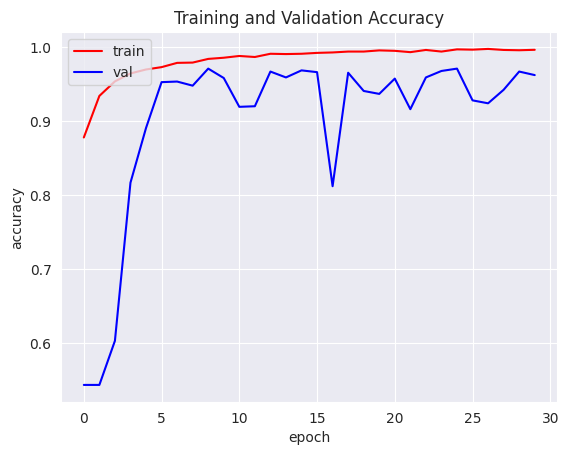

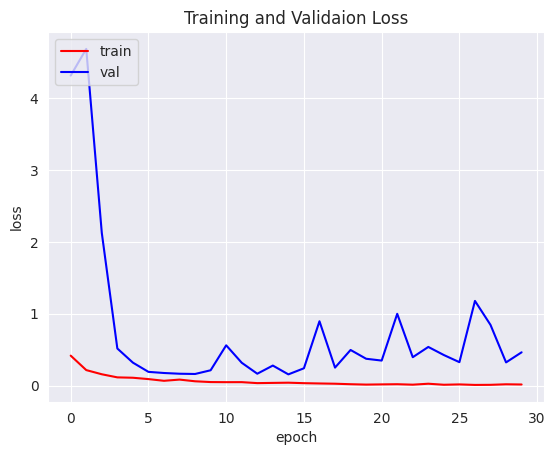

In [41]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
    
epochs = range(len(acc))
    
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
    
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

/home/nadia/.local/share/virtualenvs/finalProject-klEDiN5O/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()




              precision    recall  f1-score   support

      Normal     0.9569    0.9704    0.9636       710
   Pneumonia     0.9754    0.9640    0.9697       862

    accuracy                         0.9669      1572
   macro avg     0.9661    0.9672    0.9666      1572
weighted avg     0.9670    0.9669    0.9669      1572



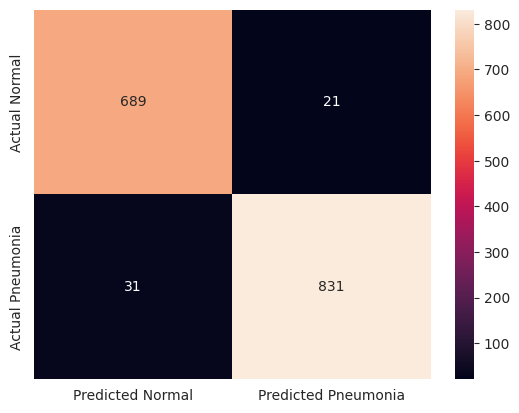

In [42]:
test_generator.reset()
    
preds_1 = model_1.predict(test_generator,verbose=0)
preds_1 = preds_1.copy()
preds_1[preds_1 <= 0.5] = 0
preds_1[preds_1 > 0.5] = 1
    
# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")
    
# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_1,target_names =['Normal','Pneumonia'], digits=4))